# Random Forest Baseline - LB 0.664
In this notebook we present a Random Forest baseline. We train GroupKFold models for each of the 18 questions. Our CV score is 0.664. We infer test using one of our KFold models. We can improve our CV and LB by engineering more features for our random forest and/or trying different models (like other ML models and/or RNN and/or Transformer). Also we can improve our LB by using more KFold models OR training one model using all data (and the hyperparameters that we found from our KFold cross validation).

In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Load Train Data and Labels

In [2]:
train = pd.read_csv('data/train.csv')
print( train.shape )
train.head()

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [3]:
targets = pd.read_csv('data/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(212022, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


# Feature Engineer
We create basic aggregate features. Try creating more features to boost CV and LB!

In [4]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

In [5]:
def feature_engineer(train):
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [6]:
%%time
df = feature_engineer(train)
print( df.shape )
df.head()

(35337, 22)
CPU times: user 20.2 s, sys: 2.39 s, total: 22.6 s
Wall time: 22.7 s


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044872,2389.500000,49246.539458,1.230975,-1.000000,399.296040,129.292411,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347170,...,379.301020,899.925926,126666.129584,2.358652,-1.000000,622.061375,230.370874,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784906,969.333333,80175.676658,2.096919,-1.000000,357.227700,137.409476,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045960,...,370.723077,1378.750000,67372.714092,1.232616,0.000000,445.980040,156.186242,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762282,...,387.930077,720.384921,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


# Train Random Forest Model
We train one model for each of 18 questions. Furthermore, we use data from `level_groups = '0-4'` to train model for questions 1-3, and `level groups '5-12'` to train questions 4 thru 13 and `level groups '13-22'` to train questions 14 thru 18. Because this is the data we get (to predict corresponding questions) from Kaggle's inference API during test inference. We can improve our model by saving a user's previous data from earlier `level_groups` and using that to predict future `level_groups`.

In [7]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 21 features
We will train with 11779 users info


In [8]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf = RandomForestClassifier() 
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


# Compute CV Score
We need to convert prediction probabilities into `1s` and `0s`. The competition metric is F1 Score which is the harmonic mean of precision and recall. Let's find the optimal threshold for `p > threshold` when to predict `1` and when to predict `0` to maximize F1 Score.

In [9]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [10]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

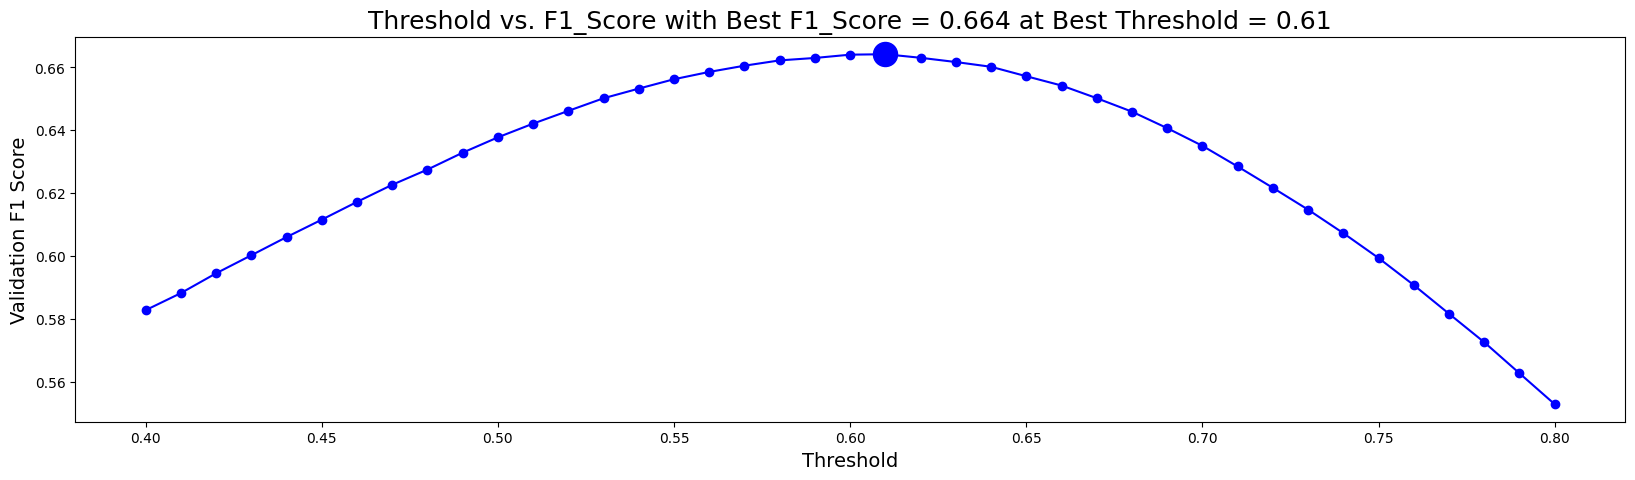

In [11]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [12]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5531707428813911
Q1: F1 = 0.4945936668669012
Q2: F1 = 0.4819229415904293
Q3: F1 = 0.5806761494426353
Q4: F1 = 0.5478265786041123
Q5: F1 = 0.5864637847428625
Q6: F1 = 0.5778057320342376
Q7: F1 = 0.538577007904268
Q8: F1 = 0.5887333044629299
Q9: F1 = 0.5057921442276779
Q10: F1 = 0.5671521854003526
Q11: F1 = 0.49296939822276836
Q12: F1 = 0.43374355354868516
Q13: F1 = 0.5868799580398174
Q14: F1 = 0.4860397031402619
Q15: F1 = 0.4885354207560846
Q16: F1 = 0.5313977321078744
Q17: F1 = 0.4939076466575357
==> Overall F1 = 0.6642128419230746


# Infer Test Data

In [13]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

ModuleNotFoundError: No module named 'jo_wilder'

In [ ]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (sample_submission, test) in iter_test:
    
    df = feature_engineer(test)
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[:,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int(p.item()>best_threshold)
    
    env.predict(sample_submission)

# EDA submission.csv

In [ ]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

In [ ]:
print(df.correct.mean())